# **`BIỂU ĐỒ CÂU CHUYỆN PHỤ`**

# **`0. Load data + tiền xử lý chung`**

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

df = pd.read_csv("/Users/user/Desktop/Project_DataPreVisual_Group_1/Data/processed/train_processed.csv")

# ---- Phân nhóm PCIAT ----
def pciat_level(score):
    if score <= 30: return "Normal"
    elif score <= 49: return "Mild"
    elif score <= 79: return "Moderate"
    else: return "Severe"

df["PCIAT_Level"] = df["PCIAT-PCIAT_Total"].apply(pciat_level)

# ---- BMI Group ----
def categorize_bmi(bmi):
    if pd.isna(bmi): return None
    if bmi < 18.5: return "Underweight"
    elif bmi < 25: return "Normal"
    elif bmi < 30: return "Overweight"
    else: return "Obese"

df["BMI_Group"] = df["Physical-BMI"].apply(categorize_bmi)

# ---- Age group ----
bins = [0, 10, 13, 15, 18, 25]
labels = ["<10", "10-12", "13-15", "16-18", ">18"]
df["AgeGroup"] = pd.cut(df["Basic_Demos-Age"], bins=bins, labels=labels, right=False)


# **`CHỦ ĐỀ 1 — SỨC KHỎE TỔNG THỂ`**

## **1. BMI trung bình theo tuổi**

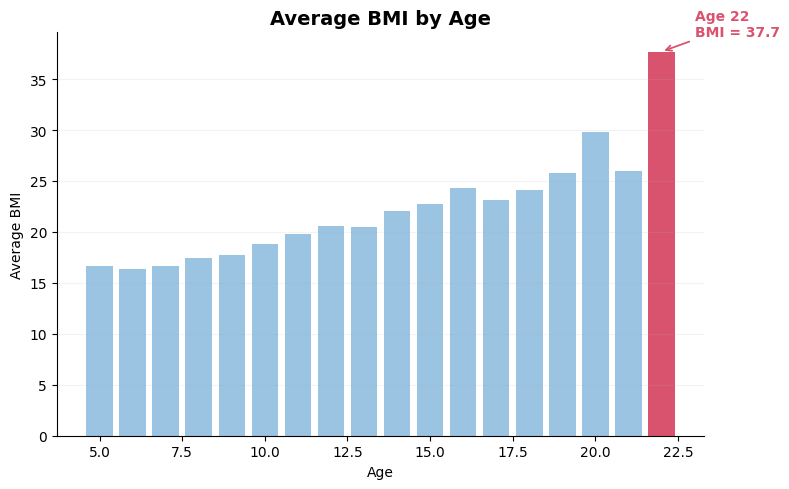

In [72]:
df_age_bmi = df.groupby("Basic_Demos-Age")["Physical-BMI"].mean().reset_index()
df_age_bmi = df_age_bmi.sort_values("Basic_Demos-Age")

max_row = df_age_bmi.loc[df_age_bmi["Physical-BMI"].idxmax()]
max_age, max_bmi = max_row["Basic_Demos-Age"], max_row["Physical-BMI"]

plt.figure(figsize=(8,5))
colors = ["#9BC4E2" if a != max_age else "#D9536F" for a in df_age_bmi["Basic_Demos-Age"]]

plt.bar(df_age_bmi["Basic_Demos-Age"], df_age_bmi["Physical-BMI"], color=colors)

plt.annotate(
    f"Age {int(max_age)}\nBMI = {max_bmi:.1f}",
    xy=(max_age, max_bmi),
    xytext=(max_age+1, max_bmi+1.5),
    arrowprops=dict(arrowstyle="->", lw=1.3, color="#D9536F"),
    color="#D9536F", fontweight="bold"
)

plt.title("Average BMI by Age", fontsize=14, fontweight="bold")
plt.xlabel("Age"); plt.ylabel("Average BMI")
plt.grid(axis='y', alpha=0.15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


## **2. % trẻ theo nhóm mỡ cơ thể**

/var/folders/yt/_mwvvxcn7_12mpyyfszzk3y80000gn/T/ipykernel_9185/1206149637.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percent, x="FatGroup", y="Percentage",


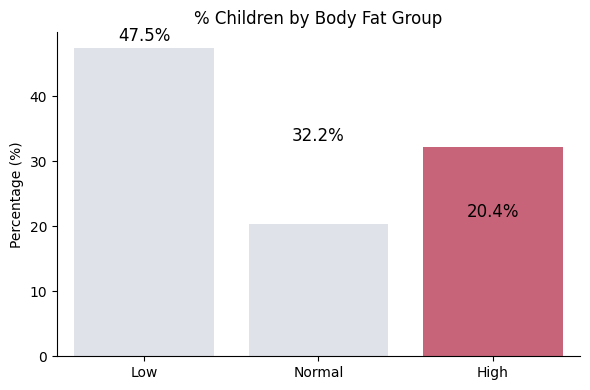

In [73]:
fat_group = pd.cut(df["BIA-BIA_Fat"],
                   bins=[0, 15, 25, 100],
                   labels=["Low", "Normal", "High"])

percent = fat_group.value_counts(normalize=True).mul(100).reset_index()
percent.columns = ["FatGroup", "Percentage"]

plt.figure(figsize=(6,4))
sns.barplot(data=percent, x="FatGroup", y="Percentage",
            palette=["#DDE3EB", "#DDE3EB", "#D9536F"])

for i, v in enumerate(percent["Percentage"]):
    plt.text(i, v+1, f"{v:.1f}%", ha='center', fontsize=12)

plt.title("% Children by Body Fat Group")
plt.ylabel("Percentage (%)"); plt.xlabel("")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


# **`CHỦ ĐỀ 2 — HOẠT ĐỘNG THỂ CHẤT`**

## **1. HFZ vs Needs Improvement**

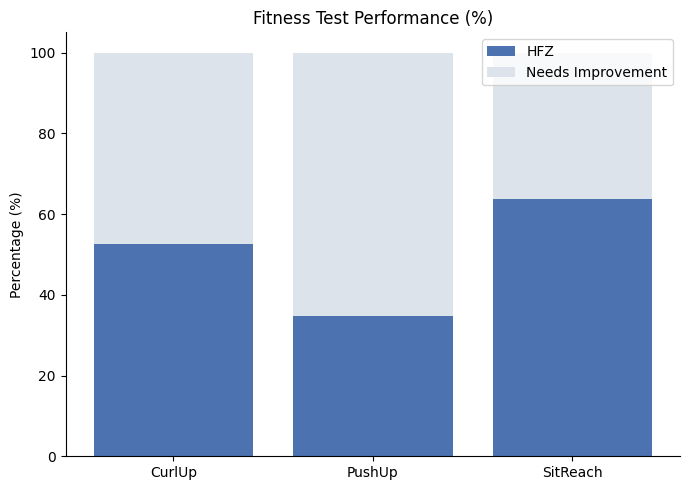

In [74]:
zones = {
    "CurlUp": "FGC-FGC_CU_Zone",
    "PushUp": "FGC-FGC_PU_Zone",
    "SitReach": "FGC-FGC_SRL_Zone"
}

records = []
for test, col in zones.items():
    total = df[col].count()
    hfz = (df[col] == 1).sum()
    ni  = (df[col] == 0).sum()
    records.append([test, hfz/total*100, ni/total*100])

df_fit = pd.DataFrame(records, columns=["Test", "HFZ", "NeedsImprovement"])

plt.figure(figsize=(7,5))
plt.bar(df_fit["Test"], df_fit["HFZ"], color="#4C72B0", label="HFZ")
plt.bar(df_fit["Test"], df_fit["NeedsImprovement"], 
        bottom=df_fit["HFZ"], color="#DDE3EB", label="Needs Improvement")

plt.title("Fitness Test Performance (%)")
plt.ylabel("Percentage (%)")
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


## **2. PAQ_C hoạt động trung bình theo mùa**

/var/folders/yt/_mwvvxcn7_12mpyyfszzk3y80000gn/T/ipykernel_9185/759861809.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_season = df.groupby("PAQ_C-Season")["PAQ_C-PAQ_C_Total"].mean().reset_index()


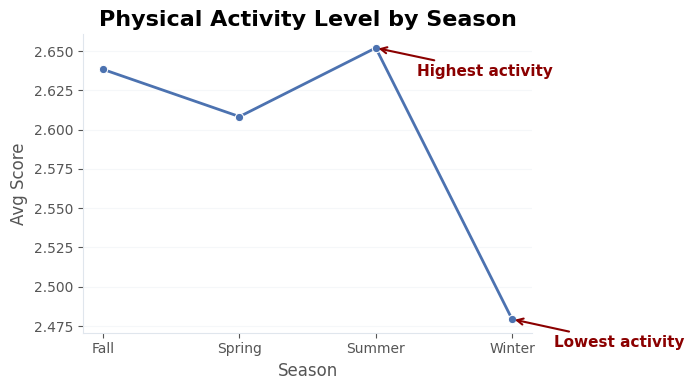

In [160]:
# --- TÍNH TRUNG BÌNH THEO MÙA ---
df_season = df.groupby("PAQ_C-Season")["PAQ_C-PAQ_C_Total"].mean().reset_index()

# Xác định mùa cao nhất và thấp nhất
max_row = df_season.loc[df_season["PAQ_C-PAQ_C_Total"].idxmax()]
min_row = df_season.loc[df_season["PAQ_C-PAQ_C_Total"].idxmin()]

plt.figure(figsize=(7,4))

# --- VẼ LINE CHART ---
sns.lineplot(
    data=df_season, 
    x="PAQ_C-Season",
    y="PAQ_C-PAQ_C_Total",
    marker="o",
    linewidth=2,
    color="#4C72B0"
)

# --- GHI CHÚ HIGH ---
plt.annotate(
    "Highest activity",
    xy=(max_row["PAQ_C-Season"], max_row["PAQ_C-PAQ_C_Total"]),
    xytext=(30, -20),
    textcoords="offset points",
    color="#8B0000",
    fontsize=11,
    fontweight="bold",
    arrowprops=dict(arrowstyle="->", color="#8B0000", lw=1.5)
)

# --- GHI CHÚ LOW ---
plt.annotate(
    "Lowest activity",
    xy=(min_row["PAQ_C-Season"], min_row["PAQ_C-PAQ_C_Total"]),
    xytext=(30, -20),
    textcoords="offset points",
    color="#8B0000",
    fontsize=11,
    fontweight="bold",
    arrowprops=dict(arrowstyle="->", color="#8B0000", lw=1.5)
)

# --- THIẾT KẾ BIỂU ĐỒ THOÁNG SẠCH ---
plt.title("Physical Activity Level by Season", fontsize=16, fontweight="bold")
plt.xlabel("Season", fontsize=12, color="#555555")
plt.ylabel("Avg Score", fontsize=12, color="#555555")

# Trục & ticks màu nhạt
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_color("#E0E6ED")
ax.spines['bottom'].set_color("#E0E6ED")

ax.tick_params(axis='x', colors='#555555')
ax.tick_params(axis='y', colors='#555555')

# Grid nhạt
plt.grid(axis='y', alpha=0.3, color="#E0E6ED")

plt.tight_layout()
plt.show()

# **`CHỦ ĐỀ 3 — THÓI QUEN INTERNET`**

## **1. % trẻ theo mức nghiện Internet**

/var/folders/yt/_mwvvxcn7_12mpyyfszzk3y80000gn/T/ipykernel_9185/3446973839.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pciat_percent,


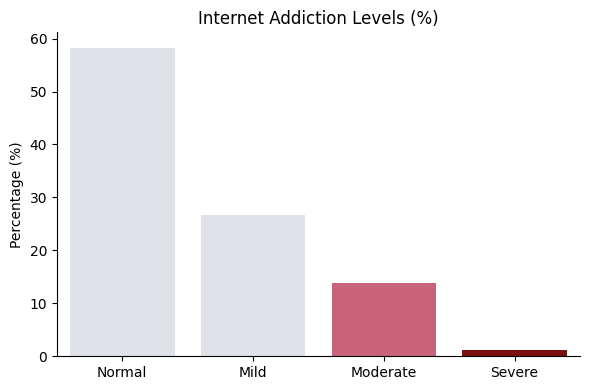

In [161]:
pciat_percent = df["PCIAT_Level"].value_counts(normalize=True).mul(100).reset_index()
pciat_percent.columns = ["Level", "Percentage"]

plt.figure(figsize=(6,4))
sns.barplot(data=pciat_percent,
            x="Level", y="Percentage",
            palette=["#DDE3EB", "#DDE3EB", "#D9536F", "#8B0000"])

plt.title("Internet Addiction Levels (%)")
plt.ylabel("Percentage (%)"); plt.xlabel("")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


## **2. Thời gian Internet trung bình theo nhóm tuổi**

/var/folders/yt/_mwvvxcn7_12mpyyfszzk3y80000gn/T/ipykernel_9185/1162206595.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_inet = df.groupby("AgeGroup")["PreInt_EduHx-computerinternet_hoursday"].mean().reset_index()


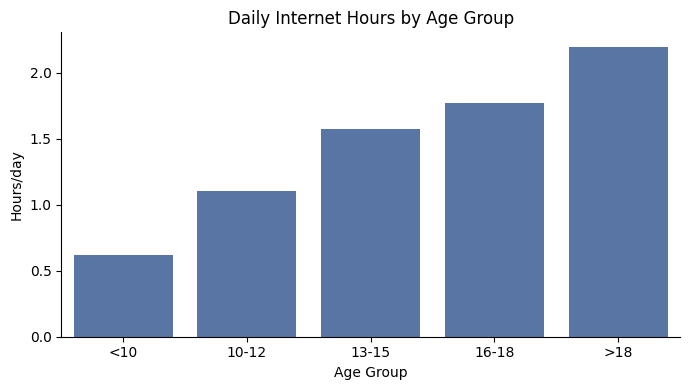

In [162]:
df_inet = df.groupby("AgeGroup")["PreInt_EduHx-computerinternet_hoursday"].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(data=df_inet,
            x="AgeGroup",
            y="PreInt_EduHx-computerinternet_hoursday",
            color="#4C72B0")

plt.title("Daily Internet Hours by Age Group")
plt.ylabel("Hours/day"); plt.xlabel("Age Group")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


# **`CHỦ ĐỀ 4 — GIẤC NGỦ & TINH THẦN`**

## **1. SDS và CGAS**

/var/folders/yt/_mwvvxcn7_12mpyyfszzk3y80000gn/T/ipykernel_9185/1745181281.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


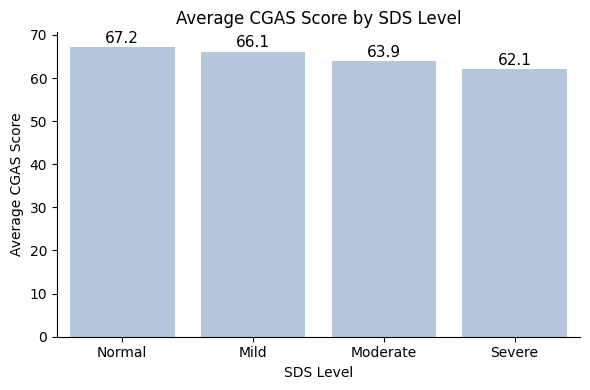

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------
# 1) Tạo SDS_Group nếu chưa có
# ---------------------------------------
def classify_sds(score):
    if score < 50:
        return "Normal"
    elif score < 60:
        return "Mild"
    elif score < 70:
        return "Moderate"
    else:
        return "Severe"

df["SDS_Group"] = df["SDS-SDS_Total_T"].apply(classify_sds)

# Sắp xếp thứ tự nhóm cho chuẩn
order = ["Normal", "Mild", "Moderate", "Severe"]

# ---------------------------------------
# 2) Tính CGAS trung bình theo SDS_Group
# ---------------------------------------
mean_cgas = (
    df.groupby("SDS_Group")["CGAS-CGAS_Score"]
      .mean()
      .reindex(order)   # đảm bảo đúng thứ tự
      .reset_index()
)

# ---------------------------------------
# 3) Vẽ biểu đồ
# ---------------------------------------
plt.figure(figsize=(6,4))
sns.barplot(
    data=mean_cgas,
    x="SDS_Group",
    y="CGAS-CGAS_Score",
    color="#AFC7E2",
    ci=None
)

# Nhãn số
for i, v in enumerate(mean_cgas["CGAS-CGAS_Score"]):
    plt.text(i, v + 1, f"{v:.1f}", ha="center", fontsize=11)

plt.title("Average CGAS Score by SDS Level")
plt.xlabel("SDS Level")
plt.ylabel("Average CGAS Score")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## **2. SDS theo tuổi**

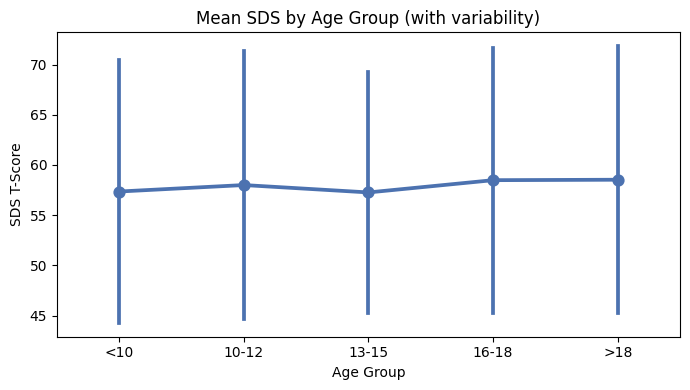

In [164]:
plt.figure(figsize=(7,4))

sns.pointplot(
    data=df,
    x="AgeGroup",
    y="SDS-SDS_Total_T",
    color="#4C72B0",
    errorbar="sd"
)

plt.title("Mean SDS by Age Group (with variability)")
plt.xlabel("Age Group")
plt.ylabel("SDS T-Score")

plt.tight_layout()
plt.show()


# **`CHỦ ĐỀ 5 — MỤC TIÊU CUỐI (TARGET: sii)`**

## **1. SII theo nhóm tuổi**

/var/folders/yt/_mwvvxcn7_12mpyyfszzk3y80000gn/T/ipykernel_9185/922738395.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sii_age = df.groupby("AgeGroup")["sii"].mean().reset_index()


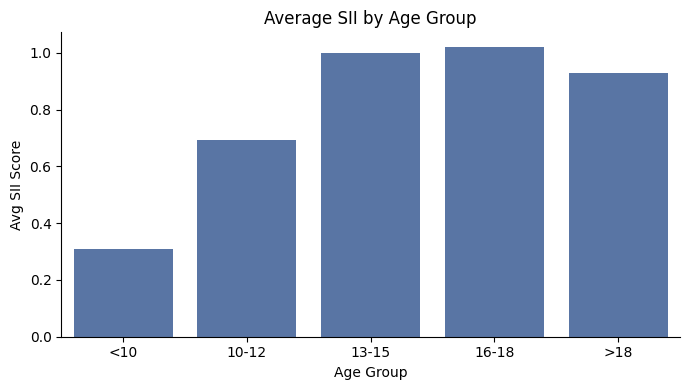

In [165]:
df_sii_age = df.groupby("AgeGroup")["sii"].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(data=df_sii_age, x="AgeGroup", y="sii", color="#4C72B0")

plt.title("Average SII by Age Group")
plt.xlabel("Age Group"); plt.ylabel("Avg SII Score")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


## **2. SII theo mức nghiện (PCIAT_Level)**

/var/folders/yt/_mwvvxcn7_12mpyyfszzk3y80000gn/T/ipykernel_9185/1754907224.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


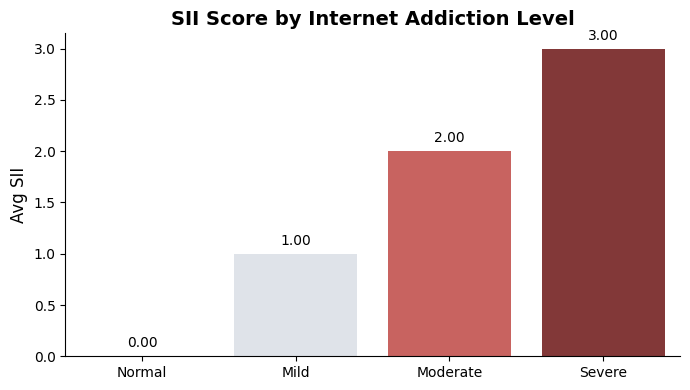

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# assume df already loaded

# Desired order for PCIAT levels (explicit)
order = ["Normal", "Mild", "Moderate", "Severe"]

# 1) Compute mean sii by PCIAT level, then reindex to ensure correct order
sii_by_level = df.groupby("PCIAT_Level")["sii"].mean().reindex(order)

# If some levels are missing in data, keep them but they will be NaN — drop or fill as you prefer
# Here we'll drop missing levels to avoid plotting NaN bars
sii_by_level = sii_by_level.dropna()

# Convert to DataFrame for plotting
df_sii_pciat = sii_by_level.reset_index()
df_sii_pciat.columns = ["PCIAT_Level", "Avg_SII"]

# 2) Define colors per category (mapping) so colors always align with labels
palette_map = {
    "Normal": "#DDE3EB",    # muted/light
    "Mild":   "#DDE3EB",    # muted/light (same as Normal)
    "Moderate":"#D9534F",   # orange highlight
    "Severe": "#8E2C2C"     # dark red strong highlight
}

# Build color list matching df_sii_pciat order
colors = [palette_map[level] for level in df_sii_pciat["PCIAT_Level"]]

# 3) Plot
plt.figure(figsize=(7,4))
ax = sns.barplot(
    data=df_sii_pciat,
    x="PCIAT_Level",
    y="Avg_SII",
    palette=colors  # palette can be a list of colors matching the rows
)

# Remove top/right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Axis labels / title
ax.set_title("SII Score by Internet Addiction Level", fontsize=14, fontweight='bold')
ax.set_xlabel("")   # no xlabel text as requested style
ax.set_ylabel("Avg SII", fontsize=12)

# Annotate bar values on top
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 0.02 * (df_sii_pciat["Avg_SII"].max() - df_sii_pciat["Avg_SII"].min()),
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


## **3. SII theo giới tính**

<Figure size 700x400 with 0 Axes>

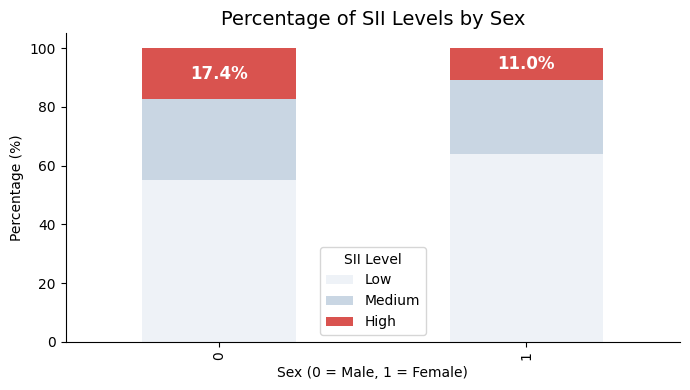

In [171]:
df_sii = df.copy()

# Phân nhóm SII
df_sii["SII_Level"] = pd.cut(
    df_sii["sii"],
    bins=[-0.1, 0.5, 1.5, 3.1],
    labels=["Low", "Medium", "High"]
)

# Bảng % theo giới tính
tbl = pd.crosstab(
    df_sii["Basic_Demos-Sex"],
    df_sii["SII_Level"],
    normalize="index"
) * 100

plt.figure(figsize=(7,4))

tbl.plot(
    kind="bar",
    stacked=True,
    figsize=(7,4),
    color=["#EEF2F7", "#C9D6E3", "#D9534F"],
    edgecolor="none"
)

# Ghi nhãn % ngay trên phần High
for idx, val in enumerate(tbl["High"]):
    plt.text(idx, 100 - val/2, f"{val:.1f}%", 
             ha="center", va="center",
             color="white", fontsize=12, fontweight="bold")

plt.title("Percentage of SII Levels by Sex", fontsize=14)
plt.xlabel("Sex (0 = Male, 1 = Female)")
plt.ylabel("Percentage (%)")
plt.legend(title="SII Level")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
